# CPSC 330 - Applied Machine Learning 

## Homework 4: Logistic regression, hyperparameter optimization 
### Associated lectures: [Lectures 7, 8](https://ubc-cs.github.io/cpsc330/README.html) 

**Due date: Friday, Feb 11, 2022 at 11:59pm**


## Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier

## Instructions 
<hr>
rubric={points:5}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2021W2/blob/main/docs/homework_instructions.md). 

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

<br><br><br><br>

## Exercise 1: Implementing `DummyClassifier` 
<hr>
rubric={points:25}

In this course (unlike CPSC 340) you will generally **not** be asked to implement machine learning algorihtms (like logistic regression) from scratch. However, this exercise is an exception: you will implement the simplest possible classifier, `DummyClassifier`.

As a reminder, `DummyClassifier` is meant as a baseline and is generally the worst possible "model" you could "fit" to a dataset. All it does is predict the most popular class in the training set. So if there are more 0s than 1s it predicts 0 every time, and if there are more 1s than 0s it predicts 1 every time. For `predict_proba` it looks at the frequencies in the training set, so if you have 30% 0's 70% 1's it predicts `[0.3 0.7]` every time. Thus, `fit` only looks at `y` (not `X`).

Below you will find starter code for a class called `MyDummyClassifier`, which has methods `fit()`, `predict()`, `predict_proba()` and `score()`. Your task is to fill in those four functions. To get your started, I have given you a `return` statement in each case that returns the correct data type: `fit` can return nothing, `predict` returns an array whose size is the number of examples, `predict_proba` returns an array whose size is the number of examples x 2, and `score` returns a number.

The next code block has some tests you can use to assess whether your code is working. 

I suggest starting with `fit` and `predict`, and making sure those are working before moving on to `predict_proba`. For `predict_proba`, you should return the frequency of each class in the training data, which is the behaviour of `DummyClassifier(strategy='prior')`. Your `score` function should call your `predict` function. Again, you can compare with `DummyClassifier` using the code below.

To simplify this question, you can assume **binary classification**, and furthermore that these classes are **encoded as 0 and 1**. In other words, you can assume that `y` contains only 0s and 1s. The real `DummyClassifier` works when you have more than two classes, and also works if the target values are encoded differently, for example as "cat", "dog", "mouse", etc.

In [2]:
class MyDummyClassifier:
    """
    A baseline classifier that predicts the most common class.
    The predicted probabilities come from the relative frequencies
    of the classes in the training data.

    This implementation only works when y only contains 0s and 1s.
    """
    def __init__(self):
        self.common_class = 0     # most common class
        self.prob = [0, 0]        # [proportion of 0, proportion of 1]
    
    def fit(self, X, y):
        counts = np.bincount(y)
        tot = y.shape[0]
        self.common_class = np.argmax(counts)
        self.prob = [(counts[0]/tot), (counts[1]/tot)]
        return None

    def predict(self, X):
        result_arr = np.full(X.shape[0], self.common_class)
        return result_arr

    def predict_proba(self, X):
        shape = X.shape[0]
        prob_arr = np.tile(self.prob,(shape,1))
        return prob_arr

    def score(self, X, y):
        predictions = self.predict(X)
        correct = np.sum(predictions == y)
        tot = y.shape[0]
        score = correct/tot
        return score

Below are some tests for `predict` using randomly generated data. You may want to run the cell a few times to make sure you explore the different cases (or automate this with a loop or random seeds).

In [3]:
# For testing, generate random data
n_train = 101
n_valid = 21
d = 5
X_train_dummy = np.random.randn(n_train, d)
X_valid_dummy = np.random.randn(n_valid, d)
y_train_dummy = np.random.randint(2, size=n_train)
y_valid_dummy = np.random.randint(2, size=n_valid)

my_dc = MyDummyClassifier()
sk_dc = DummyClassifier(strategy="prior")

my_dc.fit(X_train_dummy, y_train_dummy)
sk_dc.fit(X_train_dummy, y_train_dummy)

assert np.array_equal(my_dc.predict(X_train_dummy), sk_dc.predict(X_train_dummy))
assert np.array_equal(my_dc.predict(X_valid_dummy), sk_dc.predict(X_valid_dummy))

Below are some tests for `predict_proba`.

In [4]:
assert np.allclose(
    my_dc.predict_proba(X_train_dummy), sk_dc.predict_proba(X_train_dummy)
)
assert np.allclose(
    my_dc.predict_proba(X_valid_dummy), sk_dc.predict_proba(X_valid_dummy)
)

Below are some tests for `score`.

In [5]:
assert np.isclose(
    my_dc.score(X_train_dummy, y_train_dummy), sk_dc.score(X_train_dummy, y_train_dummy)
)
assert np.isclose(
    my_dc.score(X_valid_dummy, y_valid_dummy), sk_dc.score(X_valid_dummy, y_valid_dummy)
)

<br><br><br><br>

## Exercise 2: Trump Tweets
<hr>

For the rest of this assignment we'll be looking at a [dataset of Donald Trump's tweets](https://www.kaggle.com/austinreese/trump-tweets) as of June 2020. You should start by downloading the dataset. Unzip it and move the file `realdonaldtrump.csv` into this directory. As usual, please do not submit the dataset when you submit the assignment. 

In [6]:
tweets_df = pd.read_csv("realdonaldtrump.csv", index_col=0)
tweets_df.head()

,link,content,date,retweets,favorites,mentions,hashtags
id,,,,,,,
1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [7]:
tweets_df.shape

(43352, 7)

We will be trying to predict whether a tweet will go "viral", defined as having more than 10,000 retweets:

In [8]:
y = tweets_df["retweets"] > 10_000

To make predictions, we'll be using only the content (text) of the tweet. 

In [9]:
X = tweets_df["content"]

For the purpose of this assignment, you can ignore all the other columns in the original dataset.

#### 2(a) ordering the steps
rubric={points:8}

Let's start by building a model using `CountVectorizer` and `LogisticRegression`. The code required to do this has been provided below, but in the wrong order. 

- Rearrange the lines of code to correctly fit the model and compute the cross-validation score. 
- Add a short comment to each block to describe what the code is doing.

In [10]:
# create Logistical Regression classifier, with max num. of iterations = 1000
lr = LogisticRegression(max_iter=1000)

# create CountVectorizer, with default uninformative 'stop words' in English taken out
countvec = CountVectorizer(stop_words="english")

# define pipeline with countvec transformer and lr estimator
pipe = make_pipeline(countvec, lr)

# split data into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)

# cross-validate with pipeline, saving results as a DataFrame
cross_val_results = pd.DataFrame(
    cross_validate(pipe, X_train, y_train, return_train_score=True)
)

# get mean of cross-validation results
cross_val_results.mean()

fit_time       1.244229
score_time     0.118312
test_score     0.898444
train_score    0.967952
dtype: float64

<br><br>

#### 2(b) Cross-validation fold sub-scores
rubric={points:5}

Above we averaged the scores from the 5 folds of cross-validation. 

- Print out the 5 individual scores. Reminder: `sklearn` calls them `"test_score"` but they are really (cross-)validation scores. 
- Are the 5 scores close to each other or spread far apart? (This is a bit subjective, answer to the best of your ability.)
- How does the size of this dataset (number of rows) compare to the cities dataset we have been using in class? How does this relate to the different sub-scores from the 5 folds?

In [11]:
ind_scores = cross_val_results['test_score'].tolist()
print(f"Individual cross-val scores: {ind_scores}")

Individual cross-val scores: [0.8955866523143164, 0.8980470552052898, 0.896970628940489, 0.897893280024604, 0.9038757305444478]


- The 5 scores are fairly close to one another (all around 0.89-0.90). 
- This dataset has 43352 rows, so its size is significantly larger than the cities dataset which has 210 rows. With a larger dataset, we're less likely to learn overly-specific patterns that are due to seeing only a small subset of actual data (for each fold), and as a result the cross-validation sub-scores are more consistent here.

<br><br>

#### 2(c) baseline
rubric={points:3}

By the way, are these scores any good? 

- Run `DummyClassifier` (or `MyDummyClassifier`!) on this dataset.
- Compare the `DummyClassifier` score to what you got from logistic regression above. Does logistic regression seem to be doing anything useful?
- Is it necessary to use `CountVectorizer` here? Briefly explain.

In [11]:
sk_dc.fit(X_train, y_train)
score = sk_dc.score(X_train, y_train)
print(score)

0.7353140185766132


- The DummyClassifier score (~ 0.5) is significantly lower than the logistic regression score (~ 0.89). This indicates that yes, logistic regression is doing something useful and is better than the baseline.
- It's not necessary to use CountVectorizer here, because dummy classifiers only use information from the target (y_train) to make predictions. They don't actually attempty to 'learn' from the features (x_train), so it's not necessary to transform them using CountVectorizer.

<br><br>

#### 2(d) probability scores
rubric={points:5}

Here we train a logistic regression classifier on the entire training set: 

(Note: this is relying on the `pipe` variable from 2(a) - you'll need to redefine it if you overwrote that variable in between.)

In [13]:
pipe.fit(X_train, y_train);

Using this model, find the tweet in the **test set** with the highest predicted probability of being viral. Print out the tweet and the associated probability score.

Reminder: you are free to reuse/adapt code from lecture. Please add in a small attribution, e.g. "From Lecture 7".

In [15]:
probs = pipe.predict_proba(X_test).tolist()
prob1, prob2 = map(list, zip(*probs))

# Adapted from Lec7
data_dict = {
    "y": y_test,
    "y_hat": pipe.predict(X_test).tolist(),
    #"probabilities": pipe.predict_proba(X_test).tolist(),
    "probability1": prob1,
    "probability2": prob2
}
df = pd.DataFrame(data_dict).sort_values(by='probability2', ascending=False)
df

,y,y_hat,probability1,probability2
id,,,,
1009435777992884227,True,True,3.062635e-07,9.999997e-01
1114888062884954114,True,True,3.171612e-07,9.999997e-01
1134066371510378501,True,True,3.468908e-07,9.999997e-01
1265827032707072000,True,True,7.148940e-07,9.999993e-01
1240269212871995393,True,True,7.349383e-07,9.999993e-01
...,...,...,...,...
644009575025278977,False,False,9.999996e-01,4.153567e-07
705005396818305024,False,False,9.999996e-01,3.694483e-07
539888611534340096,False,False,9.999999e-01,1.064483e-07


In [18]:
tweet = X_test.loc[1009435777992884227]
print(f"Tweet: {tweet}")
print(f"Probability Score: {df.iloc[0]['probability2']}")

Tweet: “FBI texts have revealed anti-Trump Bias.” @ FoxNews Big News, but the Fake News doesn’t want to cover. Total corruption - the Witch Hunt has turned out to be a scam! At some point soon the Mainstream Media will have to cover correctly, too big a story!
Probability Score: 0.9999996937365133


<br><br>

#### 2(e) coefficients
rubric={points:4}

We can extract the `CountVectorizer` and `LogisticRegression` objects from the `make_pipeline` object as follows:


In [17]:
vec_from_pipe = pipe.named_steps["countvectorizer"]
lr_from_pipe = pipe.named_steps["logisticregression"]

Using these extracted components above, display the 5 words with the highest coefficients and the 5 words with the smallest coefficients.

In [55]:
# TODO!!!
feature_names = vec_from_pipe.get_feature_names_out()
coeffs = lr_from_pipe.coef_

df = pd.DataFrame(data=coeffs[0],index=feature_names, columns=["Coefficients"])
df = df.sort_values(by='Coefficients', ascending=False)
print("5 Words With Highest Coefficients:")
df.head(n=5)

5 Words With Highest Coefficients:


,Coefficients
obamagate,2.854181
harassment,2.725381
coronavirus,2.529338
mini,2.527184
fake,2.484038


In [56]:
print("5 Words With Lowest Coefficients:")
df.tail(n=5)

5 Words With Lowest Coefficients:


,Coefficients
celebapprentice,-2.106414
donaldtrump,-2.184540
barackobama,-2.530430
trump2016pic,-2.666853
realdonaldtrump,-3.133571


<br><br>

#### 2(f)
rubric={points:10}

scikit-learn provides a lot of useful tools like `make_pipeline` and `cross_validate`, which are awesome. But with these fancy tools it's also easy to lose track of what is actually happening under the hood. Here, your task is to "manually" (without `Pipeline` and without `cross_validate` or `cross_val_score`) compute logistic regression's validation score on one fold (that is, train on 80% and validate on 20%) of the training data. 

You should start with the following `CountVectorizer` and `LogisticRegression` objects, as well as `X_train` and `y_train` (which you should further split):

In [57]:
countvec = CountVectorizer(stop_words="english")
lr = LogisticRegression(max_iter=1000)

Meta-comment: you might be wondering why we're going into "implementation" here if this course is about _applied_ ML. In CPSC 340, we would go all the way down into `LogisticRegression` and understand how `fit` works, line by line. Here we're not going into that at all, but I still think this type of question (and Exercise 1) is a useful middle ground. I do want you to know what is going on in `Pipeline` and in `cross_validate` even if we don't cover the details of `fit`. To get into logistic regression's `fit` requires a bunch of math; here, we're keeping it more conceptual and avoiding all those prerequisites.

In [69]:
# TODO calculate logistic regression's validation score on one fold
# TODO w/o using Pipeline, cross_validate or cross_val_score

# Split into 80/20 training / validation sets
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=123
)

# Fit countvec on training set, then use to transform X_tr, X_val
countvec.fit(X_tr)
X_tr_trans = countvec.transform(X_tr)
X_val_trans = countvec.transform(X_val)

# Fit model
lr.fit(X_tr_trans, y_tr)

# Score prediction
print("logistic regression's validation score on one fold:")
lr.score(X_val_trans, y_val)

logistic regression's validation score on one fold:


0.8983546055666616

<br><br><br><br>

## Exercise 3: hyperparameter optimization
<hr>

#### 3(a)
rubric={points:4}

The following code varies the `max_features` hyperparameter of `CountVectorizer` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `max_features`. It also prints the results. Based on the plot/output, what value of `max_features` seems best? Briefly explain.

Note: the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

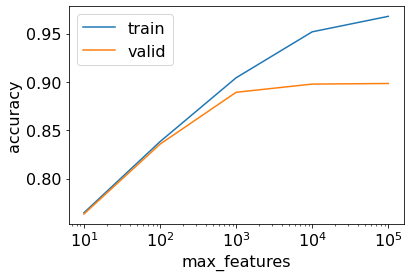

In [70]:
train_scores = []
cv_scores = []

max_features = [10, 100, 1000, 10_000, 100_000]

for mf in max_features:
    #     print(mf)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=mf),
        LogisticRegression(max_iter=1000),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)
    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(max_features, train_scores, label="train")
plt.semilogx(max_features, cv_scores, label="valid")
plt.legend()
plt.xlabel("max_features")
plt.ylabel("accuracy");

In [71]:
pd.DataFrame({"max_features": max_features, "train": train_scores, "cv": cv_scores})

,max_features,train,cv
0,10,0.764701,0.763425
1,100,0.838270,0.835671
2,1000,0.904380,0.889371
3,10000,0.951936,0.897860
4,100000,0.967952,0.898475


Based on the plot and output, setting max_features = 10^3 seems best, since it produces a high cross-validation score (relative to the scores for the other max_features), and there is only a small difference between the training and cv score. In comparison, max_features=10 and 100 produce lower cv (and train) scores, while max_features=10,000 and 100,100 produce only a slightly higher cv score but have train >> cv scores, indicating ovefitting.

<br><br>

#### 3(b)
rubric={points:4}

The following code varies the `C` hyperparameter of `LogisticRegression` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `C`. Based on the plot, what value of `C` seems best?

Note: the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

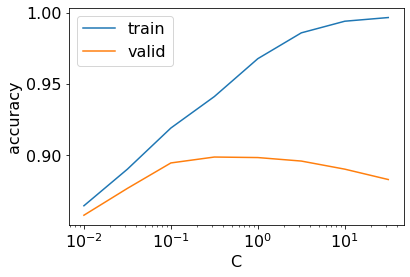

In [72]:
train_scores = []
cv_scores = []

C_vals = 10.0 ** np.arange(-2, 2, 0.5)

for C in C_vals:
    #     print(C)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=None),
        LogisticRegression(max_iter=1000, C=C),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)

    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(C_vals, train_scores, label="train")
plt.semilogx(C_vals, cv_scores, label="valid")
plt.legend()
plt.xlabel("C")
plt.ylabel("accuracy");

In [73]:
pd.DataFrame({"C": C_vals, "train": train_scores, "cv": cv_scores})

,C,train,cv
0,0.010000,0.864612,0.857969
1,0.031623,0.890316,0.876822
2,0.100000,0.919227,0.894692
3,0.316228,0.941333,0.898844
4,1.000000,0.967952,0.898475
5,3.162278,0.986091,0.896014
6,10.000000,0.994256,0.890324
7,31.622777,0.996840,0.883035


I would choose C=0.1 since it produces a high cross-validation score of ~0.89 (relative to the scores for the C values), and the difference between training and cv scores are small. In comparison, lower values of C produce lower cv (and train) scores, while higher values produce only a slightly higher cv score but have train >> cv scores, indicating ovefitting.

<br><br>

#### 3(c)
rubric={points:12}

- Using `GridSearchCV`, jointly optimize `max_features` and `C` across all the combinations of values we tried above. 
  - Note: the code might be a bit slow here. 
  - Setting `n_jobs=-1` should speed it up if you have a multi-core processor.
  - You can reduce the number of folds (e.g. `cv=2`) to speed it up if necessary.
- What are the best values of `max_features` and `C` according to your grid search?
- Do these best values agree with what you found in parts (a) and (b)?
- Generally speaking, _should_ these values agree with what you found in parts (a) and (b)? Explain.

In [81]:
# Adapted from lecture 8
pipe_gs = make_pipeline(
    CountVectorizer(stop_words="english", max_features=None),
    LogisticRegression(max_iter=1000),
)

C_vals = 10.0 ** np.arange(-2, 2, 0.5)
max_feat_vals = [10, 100, 1000, 10_000, 100_000]

#print(pipe_gs.named_steps)

param_grid = {
    "countvectorizer__max_features": max_feat_vals,
    "logisticregression__C": C_vals,
}

grid_search = GridSearchCV(
    pipe_gs, param_grid, cv=3, n_jobs=-1, return_train_score=True
)
# I only assigned it to var 'fit' to stop output from being displayed
fit = grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': [10, 100, 1000, 10000,
                                                           100000],
                         'logisticregression__C': array([1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01])},
             return_train_score=True)

In [83]:
results = pd.DataFrame(grid_search.cv_results_)[
    [
        "mean_test_score",
        "param_countvectorizer__max_features",
        "param_logisticregression__C",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index().T

display(results)

rank_test_score,1,2,3,4,5,6,7,8,9,10,...,31,32,33,33,33,33,37,38,39,40
mean_test_score,0.89666,0.896506,0.895184,0.894845,0.893769,0.891954,0.891677,0.891001,0.888633,0.886818,...,0.827336,0.814818,0.762994,0.762994,0.762994,0.762994,0.762964,0.761672,0.76078,0.745402
param_countvectorizer__max_features,100000,10000,100000,10000,100000,100000,10000,10000,100000,1000,...,100,100,10,10,10,10,10,10,10,10
param_logisticregression__C,0.316228,0.316228,1.0,1.0,3.162278,0.1,0.1,3.162278,10.0,0.316228,...,0.031623,0.01,1.0,31.622777,10.0,3.162278,0.316228,0.1,0.031623,0.01
mean_fit_time,4.076308,3.214741,4.931494,3.87579,6.026454,3.5344,2.966825,4.569768,7.228284,3.015921,...,2.619498,2.640621,2.508006,2.479706,2.607322,2.625298,2.611094,2.505704,2.474249,2.421813


- The best values of max_features = 10,000 and the best value of C = 0.316228.
- The values are different than what I found in parts a and b, which were and 0.1, respectively.
- Generally speaking, it's very reasonable for GridSearch values (part b) to be different from values found independently (part a). Values that individually lead to a high score may not have a high score when used together, hence the values in parts a and b may be different.

<br><br>

#### 3(d)
rubric={points:5}

- Evaluate your final model on the test set. 
- How does your test accuracy compare to your validation accuracy? 
- If they are different: do you think this is because you "overfitted on the validation set", or simply random luck?

In [86]:
grid_search.score(X_test, y_test)

0.9018269053330873

The test accuracy is very similar to the validation accuracy (both are ~0.89).

<br><br><br><br>

## Exercise 4: Very short answer questions
rubric={points:10}

Each question is worth 2 points. Max 2 sentences per answer.

1. What is the problem with calling `fit_transform` on your test data with `CountVectorizer`? 
2. Why is it important to follow the Golden Rule? If you violate it, will that give you a worse classifier?
3. If you could only access one of `predict` or `predict_proba`, which one would you choose? Briefly explain.
4. What are two advantages of using sklearn `Pipeline`s? 
5. What are two advantages of `RandomizedSearchCV` over `GridSearchCV`?

Answers:
1. calling fit_transform with test data in `CountVectorizor` breaks the Golden Rule because the fit step contains test data. The test data should not influence the fit step in any way!
2. It's important to follow the Golden Rule because otherwise the resulting scores are unreliable and misleading, and leads to a lack of ability to generalize to real-world data. If you violate it, it will likely give you a worse classifier, but also less reliable metrics to even tell if it's truly 'worse'.
3. I would access `predict_proba`, because I can calculate results of `predict` using `predict_proba` results (sample is in target class if probability > 0.5), but not the other way around.
4.Two advantages of using sklearn `Pipeline`s are firstly that it provides an organized way to apply preprocessing steps and then a final estimator to fit and predict, and secondly that the pipeline can be used in cross-validation, further simplifying the steps we'd otherwise have to individually specify.
5. One advantage is that `RandomizedSearchCV` is faster than `GridSearchCV`. Another advantage is that it the random layout leads to more exploration of the hyperparameter space, generally leading to better results.

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 